# EE-25620: Deep Learning

# HW3. SVHN


SVHN

[Google Street View House Number(SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/)

Much similar to MNIST(images of cropped digits), but SVHN contains much more labeled data (over 600,000 images) with real world problems of recognizing digits and numbers in *natural scene images*.

**Overview:**

1) Total 10 Classes, 1 for each digits i.e Label '9' for digit 9 and '10' for digit 0. 

2) 73,257 digits for training, 26,032 digits for testing.

3) Available in two differnet formats
Original images with bounding box available for each character (may contain multiple characters in same images).

MNIST like 32x32 cropped images having single character in each images.
Dataset is obtained from house numbers in Google Street View images.

Here we are classifying 32 x 32 cropped images given in format 2

In [ ]:
import os
import tarfile
import torch
import numpy as np

import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

import torch.nn as nn
from torch.nn import AvgPool2d
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

!pip install torchsummary
from torchsummary import summary

from scipy.io import loadmat

Loading Dateset

In [ ]:
root='http://ufldl.stanford.edu/housenumbers/'

transform = transforms.Compose([
                                transforms.CenterCrop((28, 28)),
                                transforms.ToTensor(),
                                #transforms.Normalize([0.5,],[0.5,])
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
                                ])

train = torchvision.datasets.SVHN(root, split='train', transform=transform, target_transform=None, download=True)

train_dl = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

test_vi = torchvision.datasets.SVHN(root, split='test', transform=transforms.ToTensor(),download=True)
test_vii = torch.utils.data.DataLoader(test_vi, batch_size=128, shuffle=True)

test = torchvision.datasets.SVHN(root, split='test', transform=transform, target_transform=None, download=True)

test_dl = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

images_train, labels_train = next(iter(train_dl))
images_test, labels_test = next(iter(test_dl))
images_test_vi, labels_test_vi = next(iter(test_vi))

print("Shape of train inputs: ", images_train.shape, "; Shape of train labels: ", labels_train.shape)
print("Shape of test inputs: ",images_test.shape, "; Shape of test inputs: ", labels_test.shape)
print("Batch size = 128")

Using downloaded and verified file: http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Shape of train inputs:  torch.Size([128, 3, 28, 28]) ; Shape of train labels:  torch.Size([128])
Shape of test inputs:  torch.Size([128, 3, 28, 28]) ; Shape of test inputs:  torch.Size([128])
Batch size = 128


**Visualization fo the data**

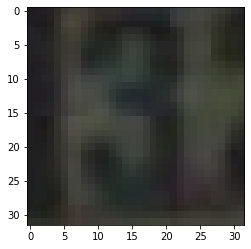

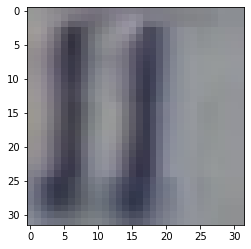

In [ ]:
def show(image):
  ig, axes = plt.subplots()
  plt.imshow(image)
dataiter = iter(test_vii)
images, labels = dataiter.next()
for i in range(113,115):
  img = images[i]
  img = img.numpy().transpose((1, 2, 0))
  show(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


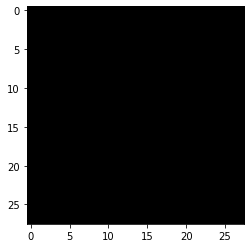

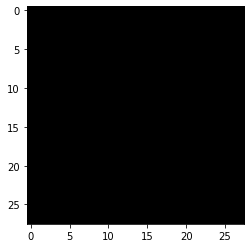

In [ ]:
 dataiter = iter(test_dl)
images, labels = dataiter.next()
for i in range(113,115):
  img = images[i]
  img = img.numpy().transpose((1, 2, 0))
  show(img)

In [ ]:
img, label = train[0]
print(img.shape, label)
img

torch.Size([3, 28, 28]) 1


tensor([[[-0.8745, -0.7647, -0.4980,  ..., -0.7412, -0.8039, -0.8196],
         [-0.8196, -0.8196, -0.5373,  ..., -0.6471, -0.5294, -0.6157],
         [-0.8275, -0.8588, -0.5922,  ..., -0.4745, -0.3569, -0.4039],
         ...,
         [-0.3569, -0.4431, -0.8196,  ..., -0.3333, -0.2078, -0.2000],
         [-0.3961, -0.4275, -0.6863,  ..., -0.2078, -0.1922, -0.1765],
         [-0.3569, -0.3725, -0.5137,  ..., -0.1765, -0.1843, -0.1843]],

        [[-0.8667, -0.7490, -0.5137,  ..., -0.8353, -0.7569, -0.7725],
         [-0.8588, -0.8039, -0.5451,  ..., -0.6314, -0.5843, -0.6627],
         [-0.8353, -0.8353, -0.5608,  ..., -0.4431, -0.4275, -0.4667],
         ...,
         [-0.4039, -0.4980, -0.8353,  ..., -0.2941, -0.2392, -0.2078],
         [-0.3647, -0.4196, -0.7020,  ..., -0.2314, -0.2000, -0.1843],
         [-0.3804, -0.3961, -0.5059,  ..., -0.1843, -0.1843, -0.1843]],

        [[-0.8196, -0.7647, -0.5765,  ..., -0.6471, -0.6941, -0.6471],
         [-0.8039, -0.8118, -0.5922,  ..., -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


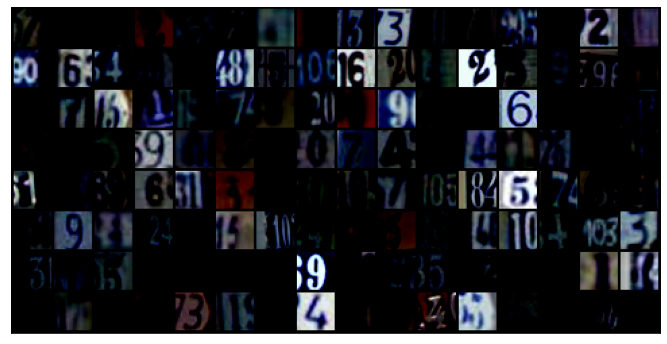

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

**Choosing hyperparameters**(TODO)

**توضیحات**

من هایپرپارامترها را در قسمت بعدتر تنظیم کردم.

معماری شبکه من به صورت چندین لایه عمیق کانولوشنالی است که از فیلترهای زیادی استفاده می شود و هم چنین به همراه آن ها، از دراپ آوت و بچ نرمالیزیشن نیز استفاده کرده ام و در انتها نیز از سه لایه فولی کانکتد.

دقت تست من به حدود 94 درصد رسیده است.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(test_dl, device)

## Convolution Neural Net (TODO)

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super(CnnModel, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3,256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Dropout(p=0.2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.2),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.2),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.2),
            nn.ReLU(inplace=True),

            nn.Conv2d(16,8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.2),
            nn.ReLU(inplace=True),

            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.Dropout(p=0.2),
            nn.ReLU(inplace=True),

        )

        self.linear_layers = nn.Sequential(
            nn.Linear(4*7*7, 2*7*7),
            nn.Dropout(p=0.2),
            nn.Linear(2*7*7, 7*7),
            nn.Dropout(p=0.2),
            nn.Linear(7*7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


In [ ]:
import torch.optim as optim

model = CnnModel()

num_epochs = 20

#opt_func = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)        ####select your optimizer####
lr = 0.001
opt_func = torch.optim.Adam
input_size = 2352
num_classes = 10


In [ ]:
model = to_device(CnnModel(), device)
print(model)

CnnModel(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.2, inplace=False)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchN

In [ ]:
if torch.cuda.is_available():
    model = model.cuda()
summary(model, input_size=(3, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 28, 28]           7,168
       BatchNorm2d-2          [-1, 256, 28, 28]             512
           Dropout-3          [-1, 256, 28, 28]               0
              ReLU-4          [-1, 256, 28, 28]               0
         MaxPool2d-5          [-1, 256, 14, 14]               0
            Conv2d-6          [-1, 128, 14, 14]         295,040
       BatchNorm2d-7          [-1, 128, 14, 14]             256
           Dropout-8          [-1, 128, 14, 14]               0
              ReLU-9          [-1, 128, 14, 14]               0
        MaxPool2d-10            [-1, 128, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          73,792
      BatchNorm2d-12             [-1, 64, 7, 7]             128
          Dropout-13             [-1, 64, 7, 7]               0
             ReLU-14             [-1, 6

In [ ]:
print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

426213
426213


In [ ]:
history = evaluate(model, val_dl)
history

{'val_acc': 0.07596762478351593, 'val_loss': 2.3089823722839355}

**In this part your performance will be evalualted**

In [ ]:
if torch.cuda.is_available():
    model = model.cuda()
    
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.1339, val_loss: 0.4881, val_acc: 0.8537
Epoch [1], train_loss: 0.5199, val_loss: 0.4446, val_acc: 0.8765
Epoch [2], train_loss: 0.4387, val_loss: 0.3559, val_acc: 0.8929
Epoch [3], train_loss: 0.3979, val_loss: 0.3325, val_acc: 0.9028
Epoch [4], train_loss: 0.3691, val_loss: 0.2942, val_acc: 0.9130
Epoch [5], train_loss: 0.3447, val_loss: 0.2900, val_acc: 0.9158
Epoch [6], train_loss: 0.3324, val_loss: 0.2710, val_acc: 0.9234
Epoch [7], train_loss: 0.3161, val_loss: 0.2688, val_acc: 0.9254
Epoch [8], train_loss: 0.3047, val_loss: 0.2594, val_acc: 0.9254
Epoch [9], train_loss: 0.2935, val_loss: 0.2482, val_acc: 0.9280
Epoch [10], train_loss: 0.2827, val_loss: 0.2394, val_acc: 0.9319
Epoch [11], train_loss: 0.2794, val_loss: 0.2517, val_acc: 0.9285
Epoch [12], train_loss: 0.2707, val_loss: 0.2301, val_acc: 0.9361
Epoch [13], train_loss: 0.2631, val_loss: 0.2212, val_acc: 0.9376
Epoch [14], train_loss: 0.2584, val_loss: 0.2263, val_acc: 0.9356
Epoch [15], train_lo

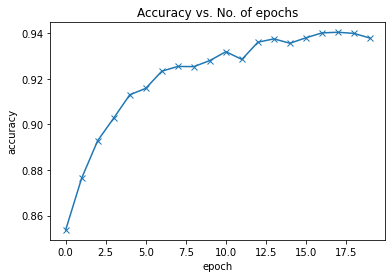

In [ ]:
plot_accuracies(history)

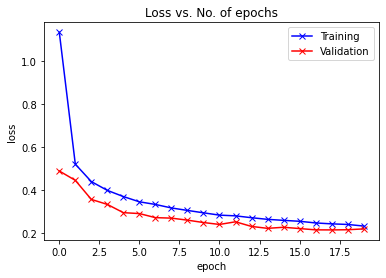

In [ ]:
plot_losses(history)


In [ ]:
torch.save(model.state_dict(), 'svhn_cnn.pth')